<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_2_Holt_Winters_Exponential_Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://ceb.udemy.com/course/forecasting-python/learn/lecture/45337473#overview

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing


# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

In [4]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
DATA_SUB_INTRO = "Exponential Smoothing and Holt Winters"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# read data

In [6]:
df = pd.read_csv(DRIVE_DATASET_PATH + "weekly_customer_complaints.csv", index_col = "week", parse_dates=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


# data visualization

In [8]:
# change the time series variable name to y
df = df.rename(columns = {"complaints": "y"})
df

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0
...,...,...,...,...,...
2022-11-28,"4,444",29.89%,0,1,0
2022-12-05,"4,920",28.48%,1,0,0
2022-12-12,"5,342",28.89%,0,0,0


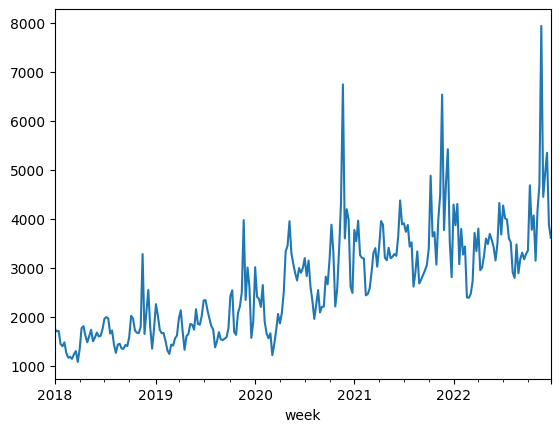

In [10]:
# time series plot
#df["y"].plot() # TypeError: no numeric data to plot
# remove the comma and convert to integer in df.y

df["y"] = df["y"].str.replace(",", "").astype(int)
df["y"].plot()

plt.show()

# Seasonality Decomposition

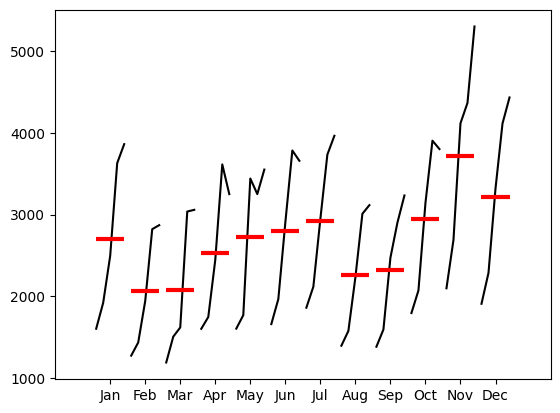

In [13]:
# Plot the month_plot for seasonality
# month_plot(df["y"]) # Expected frequency M. Got W-MON
# Our data is weekly so we need to resample it for [M]onth [E]nd

month_plot(df["y"].resample("ME").mean()) # Expected frequency M. Got W-MON
plt.show()

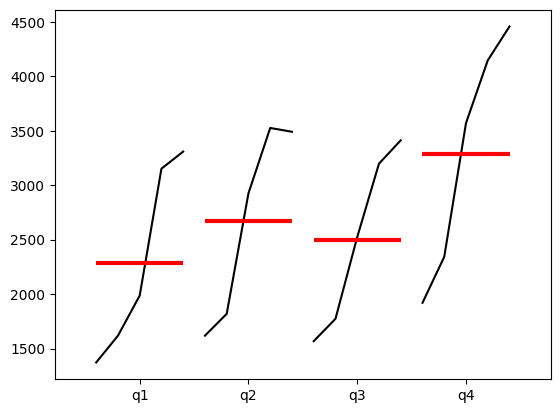

In [15]:
# Plot the quarter_plot for seasonality

quarter_plot(df["y"].resample("QE").mean())
plt.show()

##

## additive seasonal_decomposition

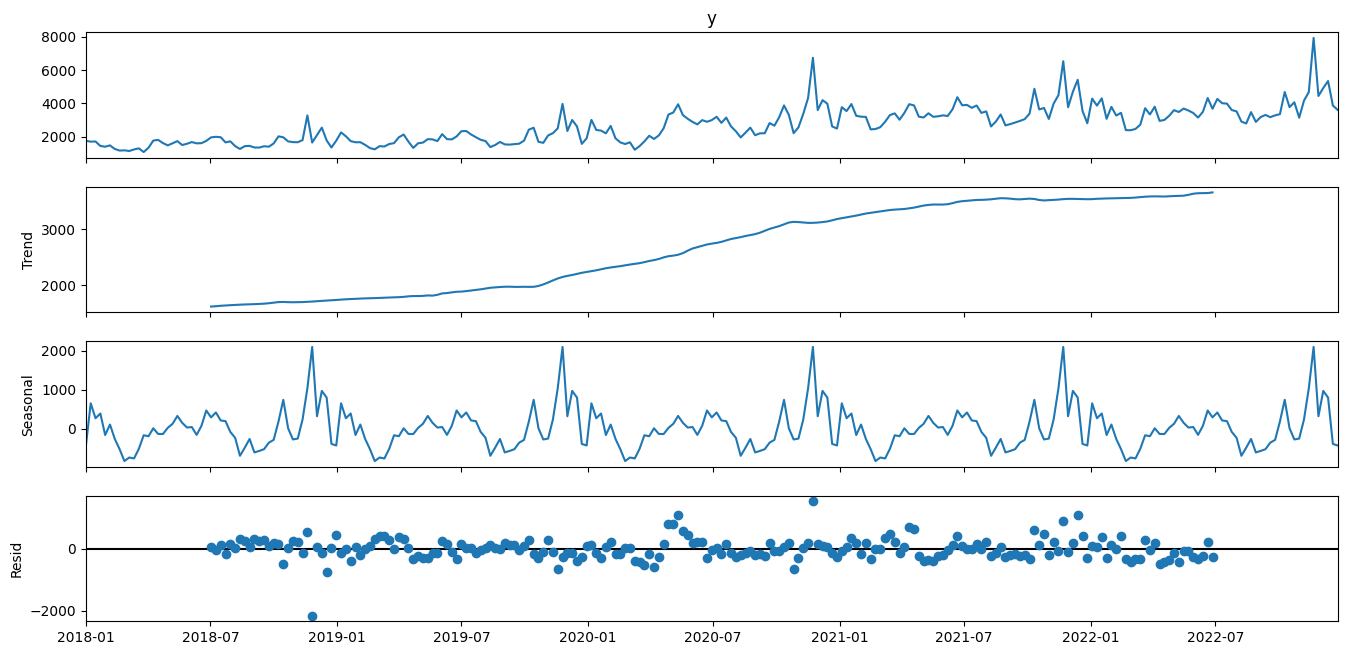

In [17]:
# Seasonal decomposition for df.y

# Our data is weekly!!!

# Seasonal decomposion might be additive (constant change) or multiplicative (percentage).
# NOTE: seasonal_decompose only allows 1 seasonality

# Lets try additive seasonal_decomposition

decomposition = seasonal_decompose(
    df["y"],
    model="additive", # multiplicative
    period = 52) # 52: complaints data is weekly so it is 52 (weeks)

fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

## multiplicative seasonal_decomposition

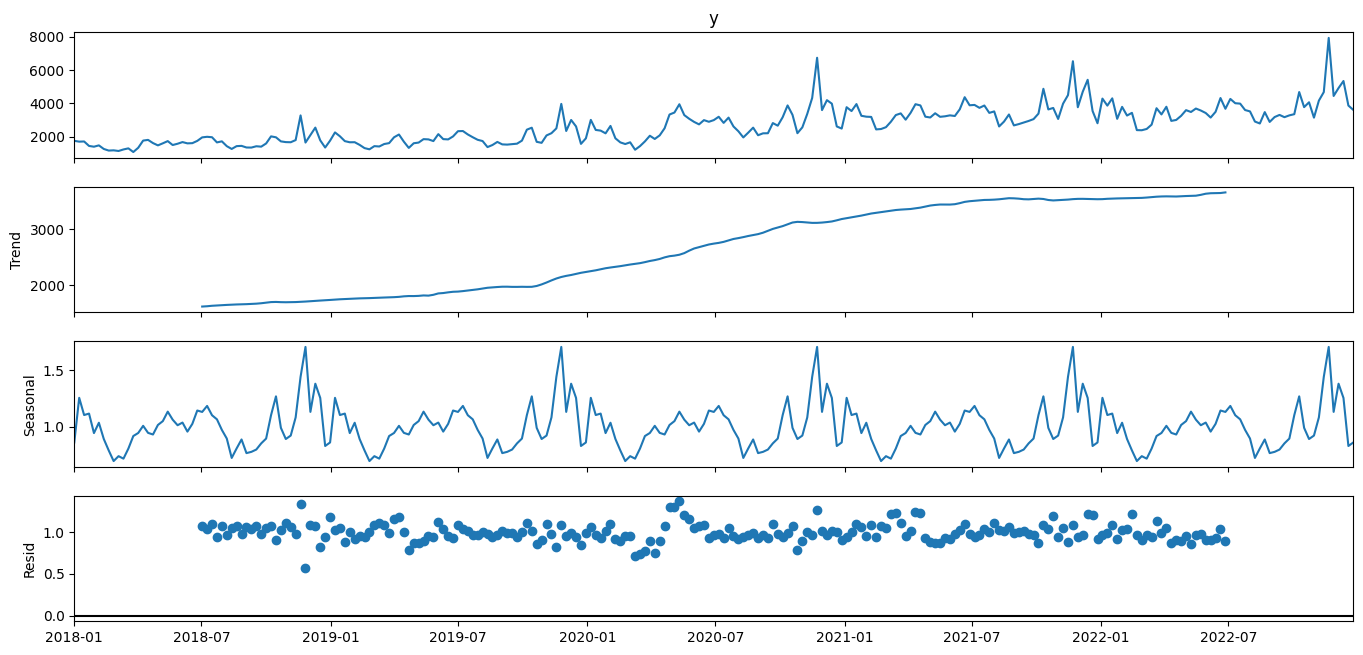

In [18]:
# Lets try multiplicative seasonal_decomposition

decomposition = seasonal_decompose(
    df["y"],
    model="multiplicative", # multiplicative
    period = 52) # 52: complaints data is weekly so it is 52 (weeks)

fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

# Auto correlation

## Auto Correlation

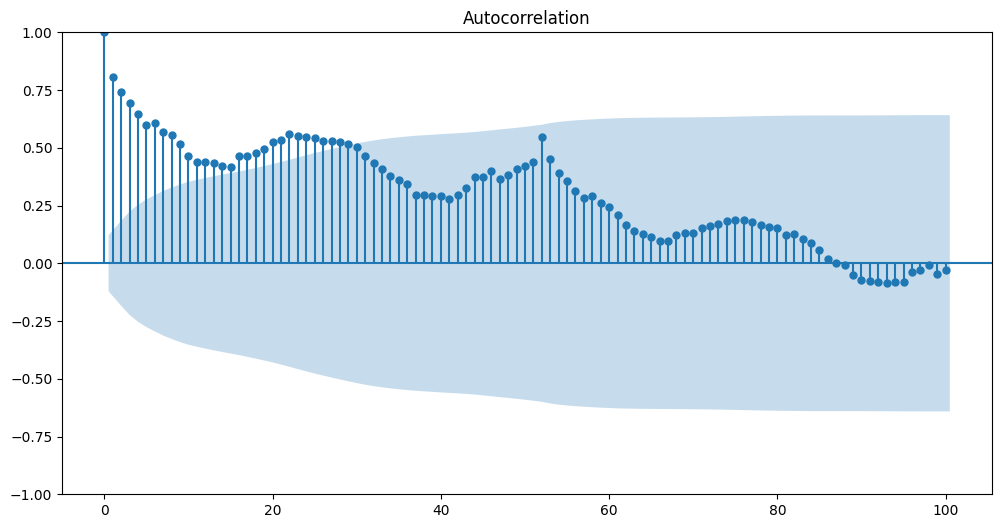

In [19]:
# Plot ACF
fig, ax =  plt.subplots(figsize = (12, 6))
plot_acf(df["y"], lags = 100, ax = ax)
plt.show()


## Partial Auto Correlation

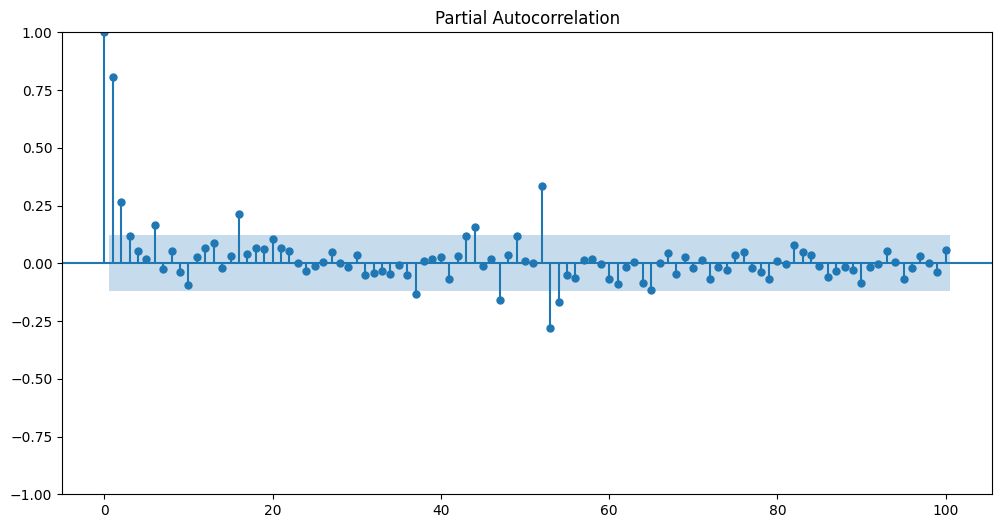

In [20]:
# Plot PACF
fig, ax =  plt.subplots(figsize = (12, 6))
plot_pacf(df["y"], lags = 100, ax = ax)
plt.show()

In [21]:
# Print the time series frequency
df.index #f req=None

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

In [24]:
# Change the frequency
# NOTE: 2018-01-01 is Monday
df = df.asfreq("W-MON")
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

# Train-Test split for time series data

*   The test length should be the desired forecasting length.
*   You should have at least 2 whole periods of data for training



## GOAL: Predict the next 13 weeks

In [28]:
# NOTE: for Exponantial smooting we can only use the target variable
periods = 13 # weeks

train = df[:-periods].y
test = df[-periods:].y
# or we can use below
# train, test = df.iloc[:-periods, 0], df.iloc[-periods:, 0]

# Exponential Smoothing

## Simple Exponential Smoothing
We are trying to find a consistent pattern in numbers
With smoothing weekly complaints, we are avoiding the surprise spikes.

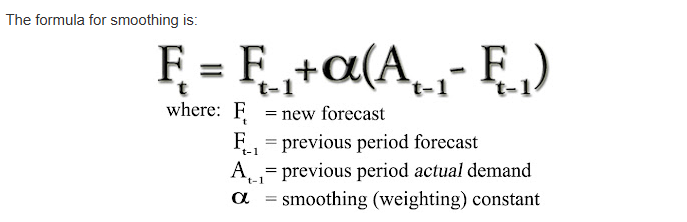

ref: https://trevorstasik.blogspot.com/2007/10/time-series-forecasting-exponential.html

In [31]:
# Apply SES (Simple Exponantial Smoothing) to the training set

# NOTE: SES do not give too much information generally.

ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355648.448
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Mon, 17 Mar 2025
Box-Cox:                        False   Time:                         10:50:35
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5115116                alpha                 True
initial_level              1750.0000                

## Double Exponential Smoothing



*   Smooths out the data (as SES does)
*   Handles the trend data
*   Does not handle seasonality
*   It basically filters the noise, revealing the sales trends.



In [32]:
# Build Double Exponential Smoothing model
model_double = ExponentialSmoothing(
    endog = train,
    trend='add', # addittive
    seasonal=None # !
    ).fit()

print(model_double.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       75700147.619
Optimized:                         True   AIC                           3139.958
Trend:                         Additive   BIC                           3154.011
Seasonal:                          None   AICC                          3140.306
Seasonal Periods:                  None   Date:                 Mon, 17 Mar 2025
Box-Cox:                          False   Time:                         11:02:34
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5212797                alpha                 True
smoothing_trend            0.01902

In [34]:
# Predict with the Double ES Model
double_pre = model_double.forecast(periods)


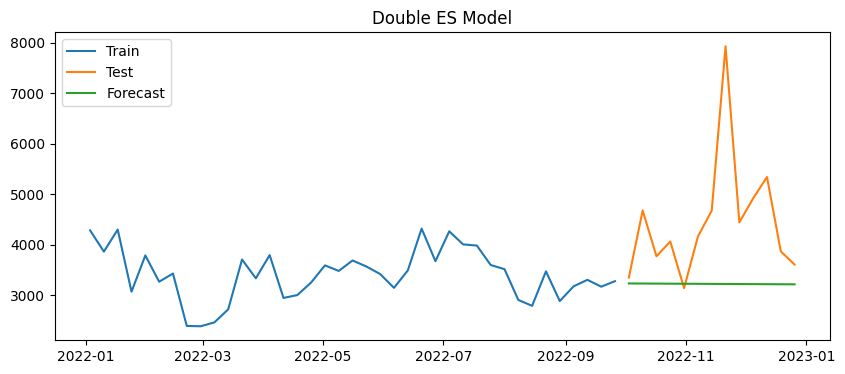

In [36]:
# Plot train, test and forecast data
plt.figure(figsize = (10, 4))

# plot data
plt.plot(train.loc["2022"], label = "Train")
plt.plot(test, label = "Test")
plt.plot(double_pre, label = "Forecast")

# add title and legend
plt.title("Double ES Model")
plt.legend()
plt.show()